# 3 layer LSTM Encoder Decoder, dropout. 30 day input, 7 day forecast

In [1]:
import numpy as np
import pandas as pd
import json
import os
import math
import datetime as dt
import matplotlib.pyplot as plt
from numpy import newaxis
from keras.optimizers import Adam
from keras.layers import Dense, Activation, Dropout, LSTM, CuDNNLSTM, BatchNormalization, RepeatVector, TimeDistributed
from keras.models import Sequential, load_model
from sklearn.metrics import mean_squared_error

import utils
import model_funcs

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [16, 9]
%matplotlib inline

Using TensorFlow backend.


In [48]:
save_dir = 'models/lstm4.7'
df = pd.read_csv('data_25_normalized.csv', index_col='Date')
data = df[['Price', 'Volume']].values

In [49]:
num_input = 120
num_out = 3
train_X, train_y, dev_X, dev_y, test_X, test_y, train_y_acc, dev_y_acc, test_y_acc = utils.prepare_data(data, num_input, num_preds=num_out)

train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y = dev_y.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y = test_y.reshape((test_y.shape[0], test_y.shape[1], 1))
train_y_acc = train_y_acc.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y_acc = dev_y_acc.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y_acc = test_y_acc.reshape((test_y.shape[0], test_y.shape[1], 1))

print("train_X shape", train_X.shape)
print("train_y shape", train_y.shape)
print("dev_X shape", dev_X.shape)
print("dev_y shape", dev_y.shape)
print("test_X shape", test_X.shape)
print("test_y shape", test_y.shape)
print("train_y_acc shape", train_y_acc.shape)
print("dev_y_acc shape", dev_y_acc.shape)
print("test_y_acc shape", test_y_acc.shape)


train_X shape (568, 120, 2)
train_y shape (568, 3, 1)
dev_X shape (71, 120, 2)
dev_y shape (71, 3, 1)
test_X shape (72, 120, 2)
test_y shape (72, 3, 1)
train_y_acc shape (568, 3, 1)
dev_y_acc shape (71, 3, 1)
test_y_acc shape (72, 3, 1)


In [52]:
if not os.path.exists(save_dir): os.makedirs(save_dir)

input_shape = train_X.shape[1:]
lr = 0.00075
decay = 1e-6
dropout_rate = 0.3
epochs = 200
batch_size = 32

model = Sequential()


model.add(CuDNNLSTM(128, input_shape=input_shape))
model.add(Dropout(dropout_rate))
model.add(BatchNormalization())

model.add(RepeatVector(num_out))

model.add(CuDNNLSTM(128, return_sequences=True))
model.add(Dropout(dropout_rate))
model.add(BatchNormalization())

model.add(CuDNNLSTM(96, return_sequences=True))
model.add(Dropout(dropout_rate))
model.add(BatchNormalization())

model.add(TimeDistributed(Dense(42, activation='relu')))
model.add(TimeDistributed(Dense(1)))

opt = Adam(lr=lr, decay=decay)
model.compile(loss="mse", optimizer=opt)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_27 (CuDNNLSTM)    (None, 128)               67584     
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 128)               512       
_________________________________________________________________
repeat_vector_10 (RepeatVect (None, 3, 128)            0         
_________________________________________________________________
cu_dnnlstm_28 (CuDNNLSTM)    (None, 3, 128)            132096    
_________________________________________________________________
dropout_20 (Dropout)         (None, 3, 128)            0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 3, 128)            512       
__________

In [53]:
history = model_funcs.train(
    model,
    train_X,
    train_y,
    (dev_X, dev_y),
    epochs = epochs,
    batch_size = batch_size,
    save_dir = save_dir
)

[Model] Training Started
[Model] 200 epochs, 32 batch size
Train on 568 samples, validate on 71 samples
Epoch 1/200
568/568 [==============================] - 2s 4ms/step - loss: 0.5783 - val_loss: 0.0356
Epoch 2/200
568/568 [==============================] - 1s 1ms/step - loss: 0.3094 - val_loss: 0.2197
Epoch 3/200
568/568 [==============================] - 1s 1ms/step - loss: 0.2013 - val_loss: 0.3915
Epoch 4/200
568/568 [==============================] - 1s 1ms/step - loss: 0.1718 - val_loss: 0.0152
Epoch 5/200
568/568 [==============================] - 1s 1ms/step - loss: 0.1365 - val_loss: 0.0518
Epoch 6/200
568/568 [==============================] - 1s 1ms/step - loss: 0.1138 - val_loss: 0.1660
Epoch 7/200
568/568 [==============================] - 1s 1ms/step - loss: 0.0982 - val_loss: 0.1373
Epoch 8/200
568/568 [==============================] - 1s 1ms/step - loss: 0.0932 - val_loss: 0.0722
Epoch 9/200
568/568 [==============================] - 1s 1ms/step - loss: 0.0818 - val_

568/568 [==============================] - 1s 1ms/step - loss: 0.0068 - val_loss: 0.0020
Epoch 81/200
568/568 [==============================] - 1s 1ms/step - loss: 0.0063 - val_loss: 0.0021
Epoch 82/200
568/568 [==============================] - 1s 1ms/step - loss: 0.0058 - val_loss: 0.0014
Epoch 83/200
568/568 [==============================] - 1s 1ms/step - loss: 0.0062 - val_loss: 0.0014
Epoch 84/200
568/568 [==============================] - 1s 1ms/step - loss: 0.0059 - val_loss: 0.0018
Epoch 85/200
568/568 [==============================] - 1s 1ms/step - loss: 0.0065 - val_loss: 0.0020
Epoch 86/200
568/568 [==============================] - 1s 1ms/step - loss: 0.0064 - val_loss: 0.0023
Epoch 87/200
568/568 [==============================] - 1s 1ms/step - loss: 0.0064 - val_loss: 0.0019
Epoch 88/200
568/568 [==============================] - 1s 1ms/step - loss: 0.0061 - val_loss: 0.0016
Epoch 89/200
568/568 [==============================] - 1s 1ms/step - loss: 0.0064 - val_loss: 

Epoch 160/200
568/568 [==============================] - 1s 1ms/step - loss: 0.0036 - val_loss: 0.0097
Epoch 161/200
568/568 [==============================] - 1s 1ms/step - loss: 0.0040 - val_loss: 0.0033
Epoch 162/200
568/568 [==============================] - 1s 1ms/step - loss: 0.0035 - val_loss: 0.0025
Epoch 163/200
568/568 [==============================] - 1s 1ms/step - loss: 0.0036 - val_loss: 8.6148e-04
Epoch 164/200
568/568 [==============================] - 1s 1ms/step - loss: 0.0040 - val_loss: 0.0020
Epoch 165/200
568/568 [==============================] - 1s 1ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 166/200
568/568 [==============================] - 1s 1ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 167/200
568/568 [==============================] - 1s 1ms/step - loss: 0.0037 - val_loss: 0.0048
Epoch 168/200
568/568 [==============================] - 1s 1ms/step - loss: 0.0036 - val_loss: 0.0062
Epoch 169/200
568/568 [==============================] - 1s 1ms/step 

In [54]:
preds_train = model.predict(train_X).squeeze()
preds_dev = model.predict(dev_X).squeeze()
preds_test = model.predict(test_X).squeeze()
print("MSE Train:", mean_squared_error(preds_train.reshape(-1,1), train_y.reshape(-1,1)))
print("MSE Dev:", mean_squared_error(preds_dev.reshape(-1,1), dev_y.reshape(-1,1)))
print("MSE Test:", mean_squared_error(preds_test.reshape(-1,1), test_y.reshape(-1,1)))

MSE Train: 0.0014820114043048742
MSE Dev: 0.0009447527511542072
MSE Test: 0.0009200419983346129


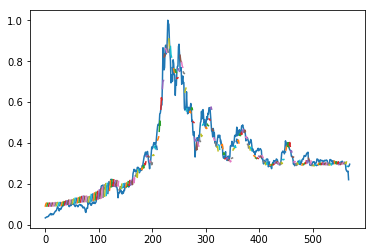

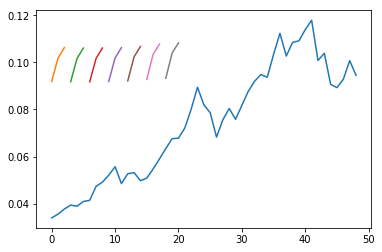

In [58]:
predicted_train = model.predict(train_X).squeeze()
predicted_train = predicted_train[::num_out]
true_train = train_y[:, 0].reshape(-1,1)
utils.plot_results_multiple(predicted_train.tolist(), true_train, num_out)

utils.plot_results_multiple(predicted_train.tolist()[:7], true_train[:49], num_out)

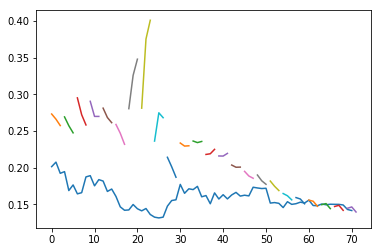

In [44]:
predicted_dev = model.predict(dev_X).squeeze()
predicted_train = predicted_train.reshape(predicted_train.shape[0], -1)
predicted_dev = predicted_dev[::num_out]
true_dev = dev_y[:, 0].reshape(-1,1)
utils.plot_results_multiple(predicted_dev.tolist(), true_dev, num_out)

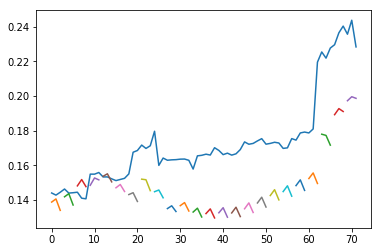

In [45]:
predicted_test = model.predict(test_X).squeeze()
predicted_test = predicted_test[::num_out]
true_test = test_y[:, 0].reshape(-1,1)
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out)

In [55]:
print("MSE Train:", mean_squared_error(predicted_train.reshape(-1,1)[:len(true_train)], true_train))
print("MSE Dev:", mean_squared_error(predicted_dev.reshape(-1,1)[:len(true_dev)], true_dev))
print("MSE Test:", mean_squared_error(predicted_test.reshape(-1,1)[:len(true_test)], true_test))

MSE Train: 0.0010508778024681832
MSE Dev: 0.006944660599970796
MSE Test: 0.0008740418943455596


In [56]:
print("Acc Train:", utils.direction_accuracy(predicted_train.reshape(-1,1)[:len(true_train)], true_train))
print("Acc Dev:", utils.direction_accuracy(predicted_dev.reshape(-1,1)[:len(true_dev)], true_dev))
print("Acc Test:", utils.direction_accuracy(predicted_test.reshape(-1,1)[:len(true_test)], true_test))

Acc Train: 0.4973544973544973
Acc Dev: 0.44285714285714284
Acc Test: 0.5070422535211268


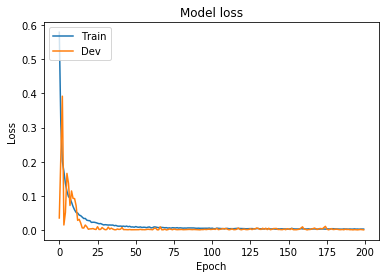

In [57]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Dev'], loc='upper left')
plt.show()